In [1]:
# Importação de libs

import os
import warnings
import joblib
import numpy as np
import pandas as pd
import unicodedata
import re

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay,
    roc_auc_score, f1_score, accuracy_score,
)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Definição de constantes
warnings.filterwarnings("ignore")
os.makedirs("models", exist_ok=True)

SEED = 42
np.random.seed(SEED)

In [3]:
# Funções Auxiliares
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normaliza nomes de colunas:
      - lowercase
      - remove acentos via NFKD
      - espaços → '_'
      - remove caracteres não-alfanuméricos
    """
    df = df.copy()
    df.columns = (
        df.columns
          .str.strip()
          .str.lower()
          .map(lambda x: unicodedata.normalize("NFKD", x)
               .encode("ascii", "ignore")
               .decode("utf-8"))
          .str.replace(r"\s+", "_", regex=True)
          .str.replace(r"[^\w_]", "", regex=True)
    )
    return df


def normalize_fase(value) -> int | float:
    """
    Converte representações heterogêneas de Fase para inteiro.
    'ALFA' → 0  |  'Fase 3 (EF)' → 3  |  5 → 5  |  NaN → NaN
    """
    if pd.isna(value):
        return np.nan
    if isinstance(value, (int, float, np.integer, np.floating)):
        return int(value)
    s = str(value).strip().upper()
    if "ALFA" in s:
        return 0
    m = re.search(r"(\d+)", s)
    return int(m.group(1)) if m else np.nan

In [4]:
# Carga do dataset
FILE_PATH = "BASE DE DADOS PEDE 2024 - DATATHON.xlsx"

if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(
        f"\nArquivo '{FILE_PATH}' não encontrado.\n"
        "Certifique-se de que o .xlsx está na mesma pasta deste script."
    )

with pd.ExcelFile(FILE_PATH) as xls:
    df_2022_raw = pd.read_excel(xls, sheet_name="PEDE2022")
    df_2023_raw = pd.read_excel(xls, sheet_name="PEDE2023")
    df_2024_raw = pd.read_excel(xls, sheet_name="PEDE2024")

# Limpa nomes de colunas em todas as abas
df_2022 = clean_columns(df_2022_raw)
df_2023 = clean_columns(df_2023_raw)
df_2024 = clean_columns(df_2024_raw)

In [5]:
# Normalização das colunas de cada ano
def normalize_to_canonical(df: pd.DataFrame, ano: int) -> pd.DataFrame:
    """
    Renomeia colunas com sufixo de ano para nomes canônicos.
    Ex: 'inde_22' → 'inde', 'pedra_23' → 'pedra', 'idade_24' → 'idade'.
    Também adiciona coluna 'ano_referencia'.
    """
    df = df.copy()
    suffix = str(ano)[2:]  # '22', '23', '24'

    # Detecta colunas com sufixo do ano atual e cria mapeamento dinâmico
    rename_map = {}
    for col in df.columns:
        if col.endswith(f"_{suffix}"):
            canonical = col[: -(len(suffix) + 1)]   # remove '_22' do final
            # Só renomeia se o nome canônico NÃO existir já no df
            # (evita duplicatas — raiz do bug original)
            if canonical not in df.columns:
                rename_map[col] = canonical

    df = df.rename(columns=rename_map)
    df["ano_referencia"] = ano

    # Normaliza coluna 'fase' (pode ter 'ALFA', 'Fase 3 (EF)', etc.)
    if "fase" in df.columns:
        df["fase"] = df["fase"].apply(normalize_fase)

    return df


df_2022 = normalize_to_canonical(df_2022, 2022)
df_2023 = normalize_to_canonical(df_2023, 2023)
df_2024 = normalize_to_canonical(df_2024, 2024)

In [12]:
# Seleção de features
# Features desejadas (schema canônico)
DESIRED_FEATURES = [
    "ra",
    "fase",
    "genero",
    "ano_ingresso",
    "instituicao_de_ensino",
    "pedra",
    "inde",
    "iaa",
    "ieg",
    "ips",
    "ida",
    "ipv",
    "ian",
    "defas",
    "atingiu_pv",
    "ano_referencia",
]

frames = []
for label, df in [("2022", df_2022), ("2023", df_2023), ("2024", df_2024)]:
    available = [c for c in DESIRED_FEATURES if c in df.columns]
    missing   = [c for c in DESIRED_FEATURES if c not in df.columns]
    if missing:
        print(f"   ⚠️ {label}: colunas ausentes → {missing}")
    frames.append(df[available].copy())

# pd.concat seguro: só funciona com índices únicos, garantido pelo copy()
df_all = pd.concat(frames, ignore_index=True)
print(f"\nDataset unificado: {df_all.shape[0]} linhas × {df_all.shape[1]} colunas")


   ⚠️ 2023: colunas ausentes → ['defas']
   ⚠️ 2024: colunas ausentes → ['pedra', 'inde', 'defas']

Dataset unificado: 3030 linhas × 16 colunas


In [13]:
# Engenharia do TARGET
df_all = df_all.dropna(subset=["atingiu_pv"]).copy()
df_all["target"] = (
    df_all["atingiu_pv"].astype(str).str.strip().str.lower() == "sim"
).astype(int)

print(f"Target — distribuição após limpeza:")
vc = df_all["target"].value_counts()
print(f"   Não atingiu PV (0): {vc.get(0, 0)} ({vc.get(0, 0)/len(df_all):.1%})")
print(f"   Atingiu PV     (1): {vc.get(1, 0)} ({vc.get(1, 0)/len(df_all):.1%})")


Target — distribuição após limpeza:
   Não atingiu PV (0): 747 (86.9%)
   Atingiu PV     (1): 113 (13.1%)


In [14]:
# Features para o modelo
# Features que NÃO devem entrar no modelo
# excluding because of over-fitting: 
#   IPV (Indicador de Ponto de Virada – Me dia das Notas de Ponto de Virada do Aluno)
EXCLUDE = {"ra", "atingiu_pv", "target", "ipv"}

# Detecta features numéricas e categóricas disponíveis
CANDIDATE_NUMERIC = [
    "fase", "inde", "iaa", "ieg", "ips", "ida", "ian",
    "defas", "ano_ingresso", "ano_referencia",
]
CANDIDATE_CATEG = [
    "genero", "instituicao_de_ensino", "pedra"
]

NUMERIC_FEATURES  = [c for c in CANDIDATE_NUMERIC if c in df_all.columns]
CATEGORICAL_FEATURES = [c for c in CANDIDATE_CATEG if c in df_all.columns]
ALL_FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES

print(f"Features numéricas   ({len(NUMERIC_FEATURES)}): {NUMERIC_FEATURES}")
print(f"Features categóricas ({len(CATEGORICAL_FEATURES)}): {CATEGORICAL_FEATURES}")

X = df_all[ALL_FEATURES].copy()
y = df_all["target"].copy()

Features numéricas   (10): ['fase', 'inde', 'iaa', 'ieg', 'ips', 'ida', 'ian', 'defas', 'ano_ingresso', 'ano_referencia']
Features categóricas (3): ['genero', 'instituicao_de_ensino', 'pedra']


In [15]:
# Divisão Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)
print(f"Treino: {len(X_train)} amostras | Teste: {len(X_test)} amostras")


Treino: 688 amostras | Teste: 172 amostras


In [17]:
# Preprocessor
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer,  NUMERIC_FEATURES),
        ("cat", categorical_transformer, CATEGORICAL_FEATURES),
    ],
    remainder="drop",
)

In [19]:
# Comparação de modelos
CANDIDATES = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=SEED),
    "Random Forest":       RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1),
    "Gradient Boosting":   GradientBoostingClassifier(n_estimators=200, random_state=SEED),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_results = {}

print("Validação cruzada 5-fold (métrica: ROC-AUC):")
for name, clf in CANDIDATES.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier",   clf),
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv,
                              scoring="roc_auc", n_jobs=-1)
    cv_results[name] = {
        "mean_auc": scores.mean(),
        "std_auc":  scores.std(),
        "pipeline": pipe,
    }
    print(f"   {name:<25s}  AUC = {scores.mean():.4f} ± {scores.std():.4f}")


Validação cruzada 5-fold (métrica: ROC-AUC):
   Logistic Regression        AUC = 0.9646 ± 0.0138
   Random Forest              AUC = 0.9412 ± 0.0145
   Gradient Boosting          AUC = 0.9378 ± 0.0391


In [22]:
# Seleção do modelo e ajuste fino
best_name = max(cv_results, key=lambda k: cv_results[k]["mean_auc"])
print(f"Melhor algoritmo: {best_name}  "
      f"(AUC médio = {cv_results[best_name]['mean_auc']:.4f})")

# Grids específicos por algoritmo
PARAM_GRIDS = {
    "Random Forest": {
        "classifier__n_estimators":    [100, 300],
        "classifier__max_depth":       [None, 10, 20],
        "classifier__min_samples_split": [2, 5],
    },
    "Gradient Boosting": {
        "classifier__n_estimators":  [100, 200],
        "classifier__learning_rate": [0.05, 0.1],
        "classifier__max_depth":     [3, 5],
    },
    "Logistic Regression": {
        "classifier__C":       [0.01, 0.1, 1, 10],
        "classifier__penalty": ["l2"],
        "classifier__solver":  ["lbfgs"],
    },
}

param_grid    = PARAM_GRIDS[best_name]
best_pipeline = cv_results[best_name]["pipeline"]

print(f"   Executando GridSearchCV para {best_name}...")
gs = GridSearchCV(
    best_pipeline, param_grid,
    cv=cv, scoring="roc_auc", n_jobs=-1, verbose=1,
)
gs.fit(X_train, y_train)
final_pipeline = gs.best_estimator_

print(f"   Melhores parâmetros : {gs.best_params_}")
print(f"   Melhor AUC (CV)     : {gs.best_score_:.4f}")

Melhor algoritmo: Logistic Regression  (AUC médio = 0.9646)
   Executando GridSearchCV para Logistic Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
   Melhores parâmetros : {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
   Melhor AUC (CV)     : 0.9875


Resultados no conjunto de TESTE:
   Acurácia  : 0.8895
   F1-Score  : 0.5366
   ROC-AUC   : 0.9469

   Classification Report:
                precision    recall  f1-score   support

Não atingiu PV       0.92      0.95      0.94       149
    Atingiu PV       0.61      0.48      0.54        23

      accuracy                           0.89       172
     macro avg       0.77      0.72      0.74       172
  weighted avg       0.88      0.89      0.88       172



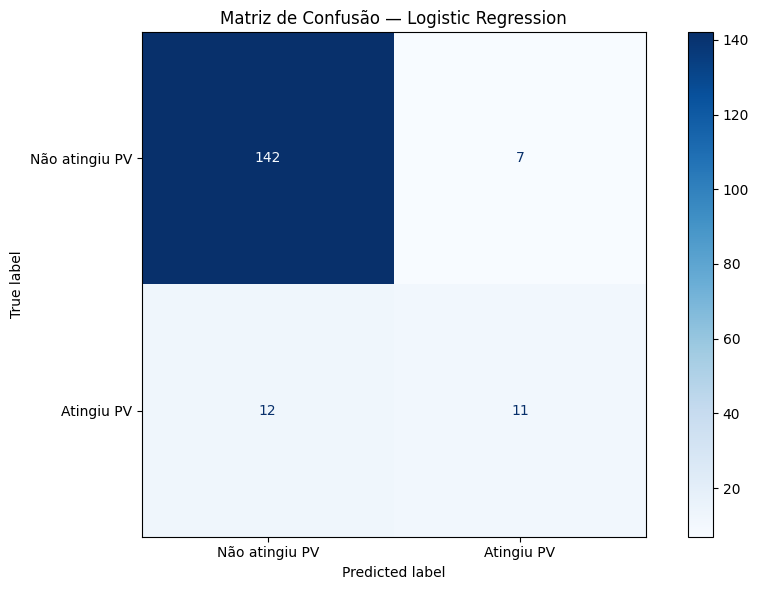

In [25]:
# Avaliação no conjunto de teste
y_pred      = final_pipeline.predict(X_test)
y_pred_prob = final_pipeline.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Resultados no conjunto de TESTE:")
print(f"   Acurácia  : {acc:.4f}")
print(f"   F1-Score  : {f1:.4f}")
print(f"   ROC-AUC   : {auc:.4f}")
print(f"\n   Classification Report:")
print(classification_report(y_test, y_pred,
                             target_names=["Não atingiu PV", "Atingiu PV"]))

# Matriz de confusão
fig, ax = plt.subplots(figsize=(9, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["Não atingiu PV", "Atingiu PV"],
    cmap="Blues", ax=ax,
)
ax.set_title(f"Matriz de Confusão — {best_name}")
plt.tight_layout()
plt.show()

In [ ]:
# Importância de features, se houver
clf_step = final_pipeline.named_steps["classifier"]
pre_step = final_pipeline.named_steps["preprocessor"]

if hasattr(clf_step, "feature_importances_"):
    # Recupera nomes das features após o OneHotEncoder
    cat_names = (
        pre_step
        .named_transformers_["cat"]
        .named_steps["onehot"]
        .get_feature_names_out(CATEGORICAL_FEATURES)
        .tolist()
    )
    feature_names = NUMERIC_FEATURES + cat_names
    importances   = clf_step.feature_importances_

    fi_df = (
        pd.DataFrame({"feature": feature_names, "importance": importances})
          .sort_values("importance", ascending=False)
          .head(15)
          .reset_index(drop=True)
    )

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(data=fi_df, x="importance", y="feature", ax=ax, palette="viridis")
    ax.set_title(f"Top 15 Features por Importância — {best_name}", fontweight="bold")
    ax.set_xlabel("Importância")
    ax.set_ylabel("")
    plt.tight_layout()
    plt.show()
    print(f"\n   Top 5 features:\n{fi_df.head(5).to_string(index=False)}")

In [31]:
# Exportação de artefatos
# Pipeline completo (preprocessor + classifier) — use para inferência
joblib.dump(final_pipeline, "models/pipeline_completo.pkl")
print("models/pipeline_completo.pkl  ← use este para predições")

# Classificador isolado
joblib.dump(clf_step, "models/melhor_modelo.pkl")
print("models/melhor_modelo.pkl      ← classificador sem preprocessador")

# Metadados: features, métricas, parâmetros
feature_meta = {
    "numeric_features":     NUMERIC_FEATURES,
    "categorical_features": CATEGORICAL_FEATURES,
    "all_features":         ALL_FEATURES,
    "target_col":           "atingiu_pv",
    "target_encoding":      {"Não": 0, "Sim": 1},
    "best_model_name":      best_name,
    "best_params":          gs.best_params_,
    "cv_auc":               round(gs.best_score_, 4),
    "test_auc":             round(auc, 4),
    "test_f1":              round(f1, 4),
    "test_accuracy":        round(acc, 4),
}
joblib.dump(feature_meta, "models/feature_names.pkl")
print("models/feature_names.pkl      ← metadados do modelo")


print(f"\nTreinamento concluído!")
print(f"     Modelo   : {best_name}")
print(f"     AUC test : {feature_meta['test_auc']}")
print(f"     F1  test : {feature_meta['test_f1']}")
print(f"     Acc test : {feature_meta['test_accuracy']}")

models/pipeline_completo.pkl  ← use este para predições
models/melhor_modelo.pkl      ← classificador sem preprocessador
models/feature_names.pkl      ← metadados do modelo

Treinamento concluído!
     Modelo   : Logistic Regression
     AUC test : 0.9469
     F1  test : 0.5366
     Acc test : 0.8895
